In [1]:
import numpy as np
import pandas as pd
import warnings
import tensorflow as tf
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, TFBertModel
# 경고 메시지 무시
warnings.filterwarnings('ignore')


2023-11-27 12:25:13.068778: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-27 12:25:13.120401: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# 데이터 로드
data = pd.read_csv("./data/situation.csv")
data = data.drop(columns=["Unnamed: 0"])

In [3]:
import pandas as pd

# 새로운 데이터프레임 생성
data1 = pd.DataFrame()
data2 = pd.DataFrame()

# 원래 가사를 절반으로 나누어 두 데이터프레임에 추가
for i in range(len(data["가사"])):
    list1 = list(data["가사"][i].split(" "))
    half_length = len(list1) // 2
    first_half = " ".join(list1[:half_length])
    second_half = " ".join(list1[half_length:])
    
    # 첫 번째 데이터프레임에 추가
    data1.loc[i, "가사"] = first_half
    data1.loc[i,"태그"]=data["태그"][i]
    # 두 번째 데이터프레임에 추가
    data2.loc[i, "가사"] = second_half
    data2.loc[i,"태그"]=data["태그"][i]
# 두 데이터프레임 합치기
data = pd.concat([data1, data2], axis=0)

In [4]:
data

,가사,태그
0,Whats the use if youre nothing without it What...,drive
1,아득해 문제를 풀던 날들 아직도 어색해 이런 말을 전달하는 게 sometimes I...,drive
2,Back against the wall 차가운 blue in my blood 하늘은...,drive
3,창밖엔 비가 내려요 오늘 밤 사랑의 노래 따윈 없다고 떠들고 다닌 내가 좀 한심해져...,drive
4,oh nothing without yeah Im nothing without you...,drive
...,...,...
4253,아 바다라고 했던가 그럼 내 눈물 모두 버릴 수 있나 길을 터 보일게 나를 베어도...,walking
4254,토닥여주고 싶었다고 달래주고 싶었다고 토닥여주고 싶었다고 워 하나 하나 둘 하나 하...,walking
4255,저 바닷속 안에 예쁜 꿈을 꾸어 입어요 가시 돋친 말들을 삼키고서 뱉어내면 자라는 ...,walking
4256,태워버리다가 남김없이 사라져버릴까 차가운 말 시려워지는 맘 가는 길에 다 두고 내릴...,walking


In [5]:
# BERT 모델 및 토크나이저 로드
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
bert_model = TFBertModel.from_pretrained('bert-base-multilingual-cased')


2023-11-27 12:25:27.859147: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-27 12:25:27.866712: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-27 12:25:27.869445: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [6]:
# 감정 태그를 숫자로 매핑
tag_mapping = {tag: idx for idx, tag in enumerate(data['태그'].unique())}
inverse_tag_mapping = {v: k for k, v in tag_mapping.items()}
data['태그_encoded'] = data['태그'].map(tag_mapping)

# 데이터 분할
train,test= train_test_split(data[["가사",'태그_encoded']], test_size=0.2, random_state=42)

In [17]:
x_train = tokenizer(
    text=train.가사.tolist(),
    add_special_tokens=True,
    max_length=100,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)


x_test = tokenizer(
    text=test.가사.tolist(),
    add_special_tokens=True,
    max_length=100,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [9]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

In [23]:
max_len = 100
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense

input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
embeddings = bert_model(input_ids,attention_mask = input_mask)[0] #(0 is the last hidden states,1 means pooler_output)
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(1024, activation='relu')(out)
out = tf.keras.layers.Dropout(0.3)(out)
out = Dense(256, activation='relu')(out)
out = tf.keras.layers.Dropout(0.3)(out)
out = Dense(64, activation='relu')(out)
out = tf.keras.layers.Dropout(0.3)(out)
out = Dense(32,activation = 'relu')(out)

y = Dense(4,activation = 'softmax')(out)
    
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True
# for training bert our lr must be so small

In [24]:
optimizer = tf.keras.optimizers.legacy.Adam(
    learning_rate=5e-05, # this learning rate is for bert model , taken from huggingface website 
    
    clipnorm=1.0)

# Set loss and metrics
loss =CategoricalCrossentropy(from_logits = True)
metric = CategoricalAccuracy(),
# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

In [25]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 100)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 100)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  177853440   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 100,                                         

In [26]:
# 가사 앞뒤로 나눠서 2배로 늘린 모델
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping 콜백 정의
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 모델 학습에 EarlyStopping 콜백 적용
train_history = model.fit(
    x={'input_ids': x_train['input_ids'], 'attention_mask': x_train['attention_mask']},
    y=to_categorical(train.태그_encoded),
    validation_data=(
        {'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']},
        to_categorical(test.태그_encoded)),
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping]
)


Epoch 1/50
107/107 [==============================] - 27s 125ms/step - loss: 1.3693 - categorical_accuracy: 0.2926 - val_loss: 1.3027 - val_categorical_accuracy: 0.3322
Epoch 2/50
107/107 [==============================] - 11s 100ms/step - loss: 1.2834 - categorical_accuracy: 0.3740 - val_loss: 1.2658 - val_categorical_accuracy: 0.3797
Epoch 3/50
107/107 [==============================] - 11s 101ms/step - loss: 1.2119 - categorical_accuracy: 0.4131 - val_loss: 1.2596 - val_categorical_accuracy: 0.3727
Epoch 4/50
107/107 [==============================] - 11s 100ms/step - loss: 1.1453 - categorical_accuracy: 0.4358 - val_loss: 1.1570 - val_categorical_accuracy: 0.4484
Epoch 5/50
107/107 [==============================] - 11s 102ms/step - loss: 1.0787 - categorical_accuracy: 0.4844 - val_loss: 1.1339 - val_categorical_accuracy: 0.4883
Epoch 6/50
107/107 [==============================] - 10s 98ms/step - loss: 0.9974 - categorical_accuracy: 0.5270 - val_loss: 1.1427 - val_categorical_accu

In [23]:
train_history = model.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = to_categorical(train.태그_encoded),
    validation_data = (
    {'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']}, to_categorical(test.태그_encoded)),
    epochs=20,
    batch_size=64)

Epoch 1/20
54/54 [==============================] - 9s 168ms/step - loss: 0.9039 - balanced_accuracy: 0.6110 - val_loss: 1.3529 - val_balanced_accuracy: 0.4601
Epoch 2/20
54/54 [==============================] - 9s 168ms/step - loss: 0.8630 - balanced_accuracy: 0.6139 - val_loss: 1.4469 - val_balanced_accuracy: 0.4354
Epoch 3/20
54/54 [==============================] - 9s 168ms/step - loss: 0.8295 - balanced_accuracy: 0.6565 - val_loss: 1.3572 - val_balanced_accuracy: 0.4577
Epoch 4/20
54/54 [==============================] - 9s 168ms/step - loss: 0.7976 - balanced_accuracy: 0.6826 - val_loss: 1.3877 - val_balanced_accuracy: 0.4777
Epoch 5/20
54/54 [==============================] - 9s 168ms/step - loss: 0.7305 - balanced_accuracy: 0.7240 - val_loss: 1.5057 - val_balanced_accuracy: 0.4343
Epoch 6/20
54/54 [==============================] - 9s 169ms/step - loss: 0.7500 - balanced_accuracy: 0.7234 - val_loss: 1.4599 - val_balanced_accuracy: 0.4542
Epoch 7/20
54/54 [======================

In [27]:
# 예측 결과를 원래 태그로 변환
predictions = model.predict(
   {'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']})
predicted_tags = np.argmax(predictions, axis=1)
predicted_tags = [inverse_tag_mapping[tag] for tag in predicted_tags]

print("Predicted Tags:", predicted_tags)


54/54 [==============================] - 3s 22ms/step
Predicted Tags: ['drive', 'rest/sleep', 'walking', 'rest/sleep', 'walking', 'drive', 'training', 'training', 'drive', 'drive', 'drive', 'walking', 'drive', 'training', 'rest/sleep', 'walking', 'drive', 'training', 'walking', 'training', 'drive', 'drive', 'walking', 'walking', 'walking', 'rest/sleep', 'drive', 'drive', 'rest/sleep', 'drive', 'drive', 'rest/sleep', 'training', 'training', 'training', 'drive', 'walking', 'rest/sleep', 'training', 'walking', 'training', 'walking', 'training', 'walking', 'drive', 'walking', 'walking', 'rest/sleep', 'walking', 'walking', 'walking', 'walking', 'drive', 'drive', 'drive', 'walking', 'training', 'walking', 'walking', 'rest/sleep', 'rest/sleep', 'drive', 'walking', 'walking', 'walking', 'training', 'drive', 'drive', 'drive', 'drive', 'walking', 'rest/sleep', 'rest/sleep', 'walking', 'rest/sleep', 'drive', 'walking', 'drive', 'walking', 'rest/sleep', 'walking', 'rest/sleep', 'training', 'rest/s

In [28]:
test["예측태그"]=np.argmax(predictions, axis=1)

In [38]:
test

,가사,태그_encoded,예측태그
184,Yeah yeah yeah yeah Fever dream high in the qu...,0,3
1018,Yo Ive been walking on the street yo 유엔빌리지에서 한...,0,2
2910,OK you got me going crazy I dont know what ...,2,2
3611,처음엔 분명 안 그랬었어 마냥 좋았었어 어느 새부터 기울곤 했어 너와 내 마음이 어...,3,3
602,Lost in all the same dreams chasin where the ...,0,0
...,...,...,...
3495,가을 우체국 앞에서 그대를 기다리다 노오란 은행잎들이 바람에 날려가고 지나는 사람들...,3,1
439,어떤 것들이 이토록 눈을 흐려지게 만들까 의심 없는 My addiction 핏줄에 ...,0,3
289,I was good to you Could lay my head upon your ...,0,0
1255,빛바랜 앨범들 속에서 또 다시 나와 만난 그대는 그 계절 가장 눈부신 모습 그대로 ...,1,3


In [29]:
from sklearn.metrics import classification_report

# 예측 결과와 실제 레이블을 가지고 classification report 생성
y_true = test.태그_encoded
y_pred =np.argmax(predictions, axis=1)

report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.46      0.40      0.43       517
           1       0.64      0.53      0.58       366
           2       0.77      0.65      0.70       356
           3       0.41      0.58      0.48       465

    accuracy                           0.53      1704
   macro avg       0.57      0.54      0.55      1704
weighted avg       0.55      0.53      0.53      1704



Precision (정밀도): 양성이라고 예측한 것 중에서 실제로 양성인 비율입니다.

Class 0: 42%
Class 1: 63%
Class 2: 62%
Class 3: 32%
Recall (재현율): 실제로 양성인 것 중에서 모델이 양성이라고 예측한 비율입니다.

Class 0: 40%
Class 1: 42%
Class 2: 55%
Class 3: 45%
F1-Score (F1 점수): 정밀도와 재현율의 조화 평균입니다.

Class 0: 41%
Class 1: 51%
Class 2: 58%
Class 3: 38%
Support (지원도): 각 클래스에 대한 실제 데이터의 개수입니다.

Class 0: 274
Class 1: 175
Class 2: 181
Class 3: 222
Accuracy (정확도): 전체적으로 모델이 정확하게 예측한 비율입니다. (모든 클래스를 고려한 전체적인 성능)

Accuracy: 45%
Macro Avg (매크로 평균): 모든 클래스의 평균값을 계산한 것으로, 클래스 불균형이 존재할 때 사용됩니다.

Macro Avg Precision: 50%
Macro Avg Recall: 46%
Macro Avg F1-Score: 47%
Weighted Avg (가중 평균): 클래스별로 가중치를 두어 평균을 계산한 것으로, 클래스의 지원도에 따라 가중치가 적용됩니다.

Weighted Avg Precision: 48%
Weighted Avg Recall: 45%
Weighted Avg F1-Score: 46%
이 결과를 종합하면, 클래스 1과 클래스 2가 비교적 높은 정밀도와 재현율을 갖고 있지만, 클래스 0과 클래스 3는 성능이 낮습니다. 전체적으로 정확도는 45%로 나타났습니다. 또한, Macro 평균과 Weighted 평균에서 전체적인 성능을 확인할 수 있습니다. 클래스 간 불균형이 있을 경우 Macro 평균이 더 중요한 지표일 수 있습니다.

In [30]:
model.save_weights('./model/situation/situation2_weights')

In [31]:
model.save('./model/situation/situation2_weights.h5')

In [32]:
import matplotlib.pyplot as plt
# 시각화
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

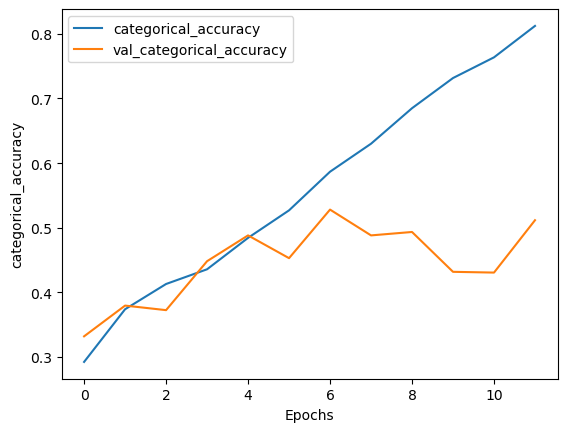

In [34]:
plot_graphs(train_history, 'categorical_accuracy')